Add CO_NLTE_excitation folder to path, and import the function elrovibpopcalc_CO which will carry out the stat equilibrium calculation

In [14]:
import numpy as np
import matplotlib.pyplot as pl
import sys
sys.path.insert(0, '../utils')
import elrovibpopcalc_CO
import importlib
importlib.reload(elrovibpopcalc_CO)

import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
font={'size':25}	
matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=2)
matplotlib.rc('xtick.major', width=2, size=8)
matplotlib.rc('xtick.minor', width=2, size=4)
matplotlib.rc('ytick.major', width=2, size=8)
matplotlib.rc('ytick.minor', width=2, size=4)
matplotlib.rc('xtick', labelsize=22)
matplotlib.rc('ytick', labelsize=22)
matplotlib.rcParams.update({'figure.autolayout': True})

Access line list/transitions LAMDA file, check that it exists

In [15]:
datafile='../files/COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat'
fname=datafile
try:
	rfile = open(fname, 'r')
except:
	print('Error!' )
	print('Excitation file was not found!')
	sys.exit() 
allfilelines=rfile.readlines() 	
rfile.close()
rfile = open(fname, 'r')

Read energy levels with degeneracies and quantum numbers from the LAMDA file, same way as in the statistical equilibrium elrovibpopcalc_CO code.

In [16]:
dum=rfile.readline()
species=rfile.readline().split()[0]
dum=rfile.readline()
mwt=float(rfile.readline().split()[0])
dum=rfile.readline()
n_levels=int(rfile.readline().split()[0])
dum=rfile.readline()

levid=np.zeros(n_levels, dtype=int)
energycmmin1=np.zeros(n_levels, dtype=float)
wt=np.zeros(n_levels, dtype=float)
qnel=np.zeros(n_levels, dtype=int)
qnvib=np.zeros(n_levels, dtype=int)
qnrot=np.zeros(n_levels, dtype=int)

for i in np.arange(n_levels):
	levid[i], energycmmin1[i], wt[i], qnel[i], qnvib[i], qnrot[i] = rfile.readline().split()
	#levid[i], energycmmin1[i], wt[i], qnrot[i] = rfile.readline().split()    #If using rotational transitions only


Read radiative transition data from LAMDA file, same way as in the statistical equilibrium elrovibpopcalc_CO code.

In [17]:
dum=rfile.readline()
ntr=int(rfile.readline().split()[0])	
dum=rfile.readline()

trid=np.zeros(ntr, dtype=int)
levup=np.zeros(ntr, dtype=int)
levdwn=np.zeros(ntr, dtype=int)
einstA=np.zeros(ntr, dtype=float)
freqghz=np.zeros(ntr, dtype=float)
eupink=np.zeros(ntr, dtype=float)

for i in np.arange(ntr):
	trid[i], levup[i], levdwn[i], einstA[i], freqghz[i], eupink[i] = rfile.readline().split()
rfile.close()

In [18]:
tgas=300.0
ncollp=5e1
distau=85.0
distpc=19.44
massmearth=4e-5
fluxallfluo=elrovibpopcalc_CO.elrovibpopcalc_COfunc(tgas=tgas, ncollp=ncollp, jnufilestar='../files/bPic_starfluxJyfromEarth.npy', datafile='../files/COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat', linewithntrcoll=114067, distpc=distpc, distau=distau, levupint='all', si=1, massmearth=massmearth)
fluxallnofluo=elrovibpopcalc_CO.elrovibpopcalc_COfunc(tgas=tgas, ncollp=ncollp, datafile='../files/COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat', linewithntrcoll=114067, distpc=distpc, distau=distau, levupint='all', si=1, massmearth=massmearth)
fracpoplevelsfluo=elrovibpopcalc_CO.elrovibpopcalc_COfunc(tgas=tgas, ncollp=ncollp, jnufilestar='../files/bPic_starfluxJyfromEarth.npy', datafile='../files/COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat', linewithntrcoll=114067, distpc=distpc, distau=distau, levupint='all')
fracpoplevelsnofluo=elrovibpopcalc_CO.elrovibpopcalc_COfunc(tgas=tgas, ncollp=ncollp, datafile='../files/COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat', linewithntrcoll=114067, distpc=distpc, distau=distau, levupint='all')

(1e-21, 1e-19)

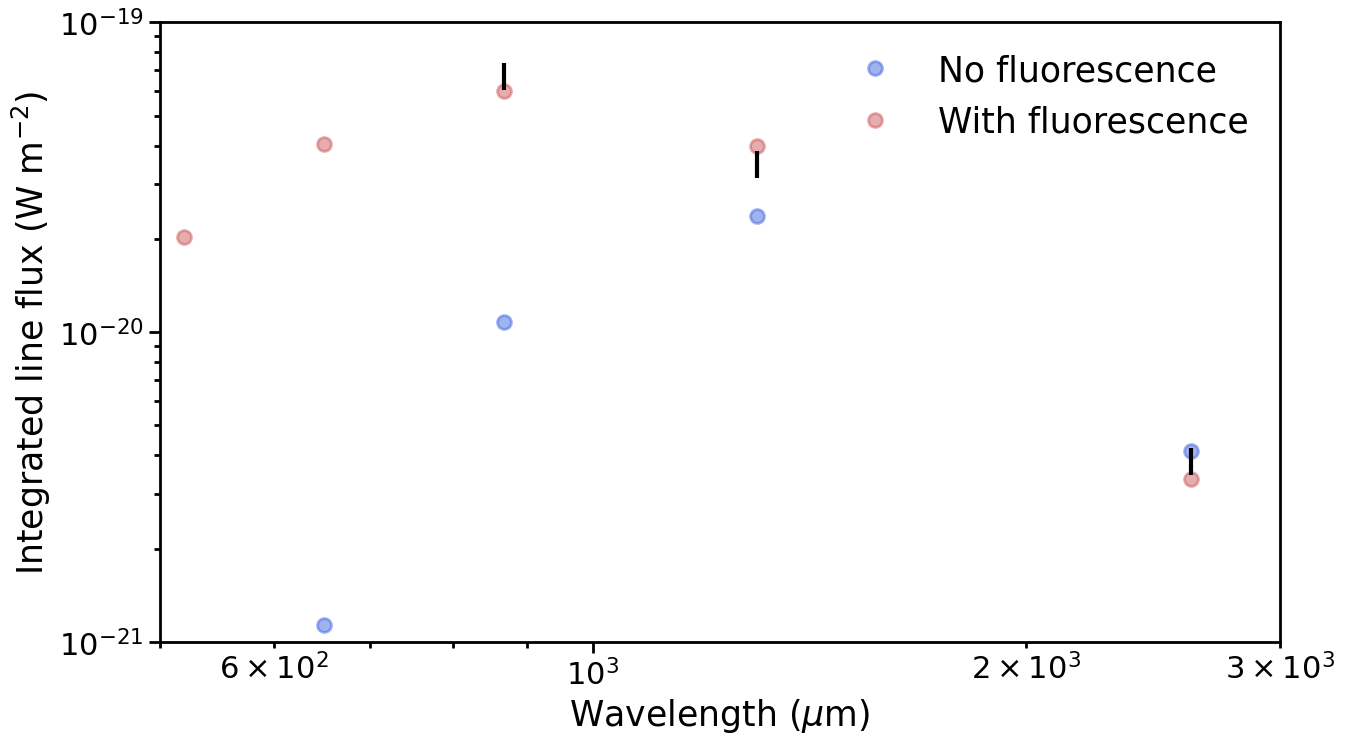

In [19]:
%matplotlib inline
pl.figure(figsize=(14,8))
#pl.plot(2.9979e8*1e6/freqghz/1e9, (fluxallfluo-fluxallfluo_corrected)/fluxallfluo, '+', color='forestgreen', mew=2, alpha=0.3, label='Fluorescence')
pl.plot(2.9979e8*1e6/freqghz/1e9, fluxallnofluo, 'o', color='royalblue', mew=2, alpha=0.5, label='No fluorescence', ms=10)
pl.plot(2.9979e8*1e6/freqghz/1e9, fluxallfluo, 'o', color='indianred', mew=2, alpha=0.5, label='With fluorescence', ms=10)
pl.xscale('log')
pl.yscale('log')
pl.ylabel(r'Integrated line flux (W m$^{-2}$)')
pl.xlabel(r'Wavelength ($\mu$m)') 
pl.legend(frameon=False)
#pl.ylim(1e-24,1e-17)
pl.xlim(1e0,4e3)

pl.errorbar(2.9979e8*1e6/np.array([115.271,230.538,345.596])/1e9, np.array([3.83e-21, 3.5e-20, 6.7e-20]), yerr=0.1*np.array([3.836e-21, 3.5e-20, 6.7e-20]),fmt='None', ms=20, elinewidth=3, color='black')
pl.xlim(5e2,3e3)
pl.ylim(1e-21,1e-19)

Try a fit

In [20]:
def log_likelihood(theta, y, yerr):
    logncoll, logmearth, d, logtgas = theta
    
    fluxallsi = elrovibpopcalc_CO.elrovibpopcalc_COfunc(tgas=10**logtgas, ncollp=10**logncoll, jnufilestar='../files/bPic_starfluxJyfromEarth.npy', datafile='../files/COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat', linewithntrcoll=114067, distpc=distpc, distau=d, levupint='all', si=1, massmearth=10**logmearth)
    model=np.array([fluxallsi[8], fluxallsi[17], fluxallsi[26]])
    sigma2 = yerr**2.0
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    logncoll, logmearth, d, logtgas = theta
    if -5 < logncoll < 10 and -6<logmearth<-4 and 50.0 < d < 150.0 and 1 < logtgas < 4:
        return 0.0
    return -np.inf

def log_probability(theta, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr)

In [21]:
import emcee
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool


startpos=[2,-5,85,2]
pos = np.array(startpos) + np.array([5e-1,1e-1,1e-1,1e-1]) * np.random.randn(40, 4)*np.array(startpos)
nwalkers, ndim = pos.shape

y=np.array([3.83e-21, 3.5e-20, 6.7e-20])
yerr=0.1*y


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(y, yerr), pool=Pool())
sampler.run_mcmc(pos, 2000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [30:46<00:00,  1.08it/s]


State([[ 6.47099639e+00 -4.33489721e+00  6.58698288e+01  1.01434808e+00]
 [-4.02456979e+00 -4.40142608e+00  7.25260836e+01  3.90950012e+00]
 [ 7.07679829e+00 -4.29190865e+00  7.40008376e+01  1.01223692e+00]
 [ 4.80105066e+00 -4.31423133e+00  1.33439301e+02  1.04713028e+00]
 [-2.41221204e+00 -4.36632934e+00  7.73367086e+01  2.76599557e+00]
 [-3.52808762e-01 -4.36070150e+00  7.69301875e+01  2.80644534e+00]
 [ 9.60526266e+00 -4.36043969e+00  1.12176072e+02  1.05050812e+00]
 [ 3.84451223e+00 -4.35025057e+00  5.56970767e+01  1.05500223e+00]
 [ 6.90764248e+00 -4.34004613e+00  1.35783386e+02  1.05595022e+00]
 [-2.38372736e+00 -4.42221297e+00  7.11262162e+01  2.83910758e+00]
 [ 1.68548838e+00 -4.37812230e+00  8.14196323e+01  3.98596516e+00]
 [ 1.62507435e+00 -4.38635186e+00  8.64692353e+01  1.44793806e+00]
 [-1.45461306e+00 -4.40021097e+00  7.39412438e+01  1.81246039e+00]
 [ 3.61320772e-01 -4.37526824e+00  7.05262081e+01  1.79545752e+00]
 [-2.24048517e+00 -4.37365482e+00  7.34981832e+01  2.477

Text(0.5, 0, 'step number')

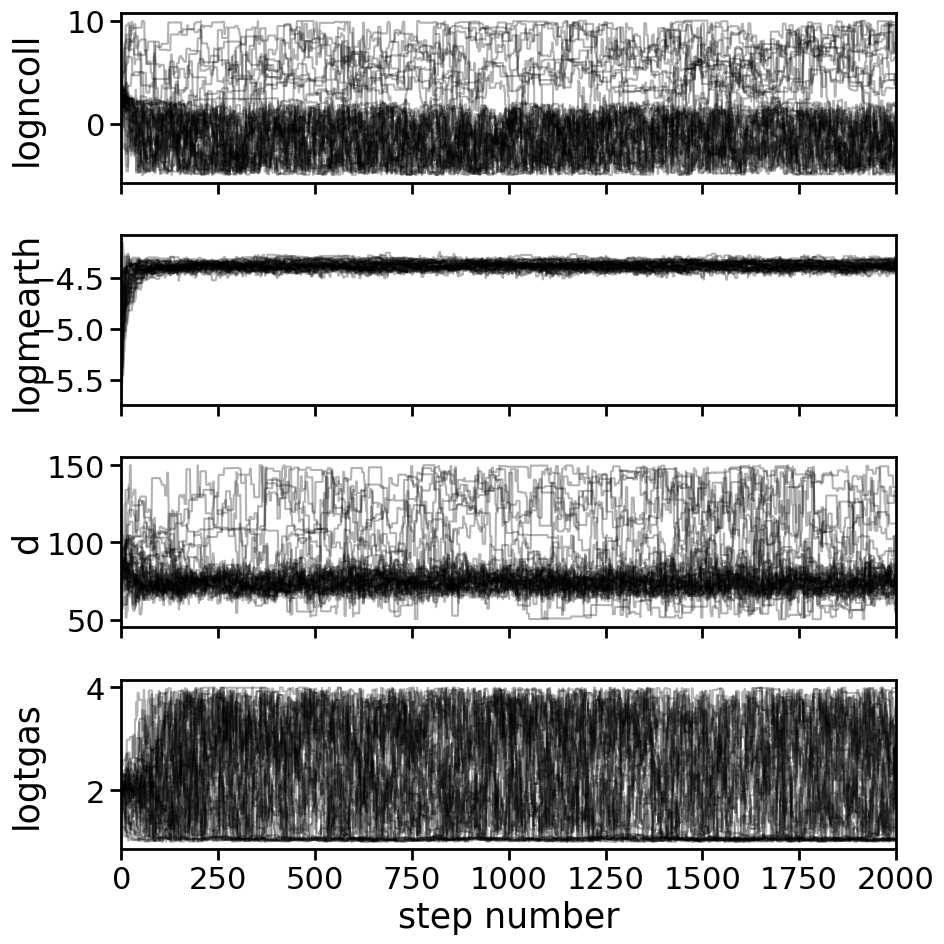

In [22]:
fig, axes = pl.subplots(4, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["logncoll", "logmearth", "d", "logtgas"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

/home/users/lmatra/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


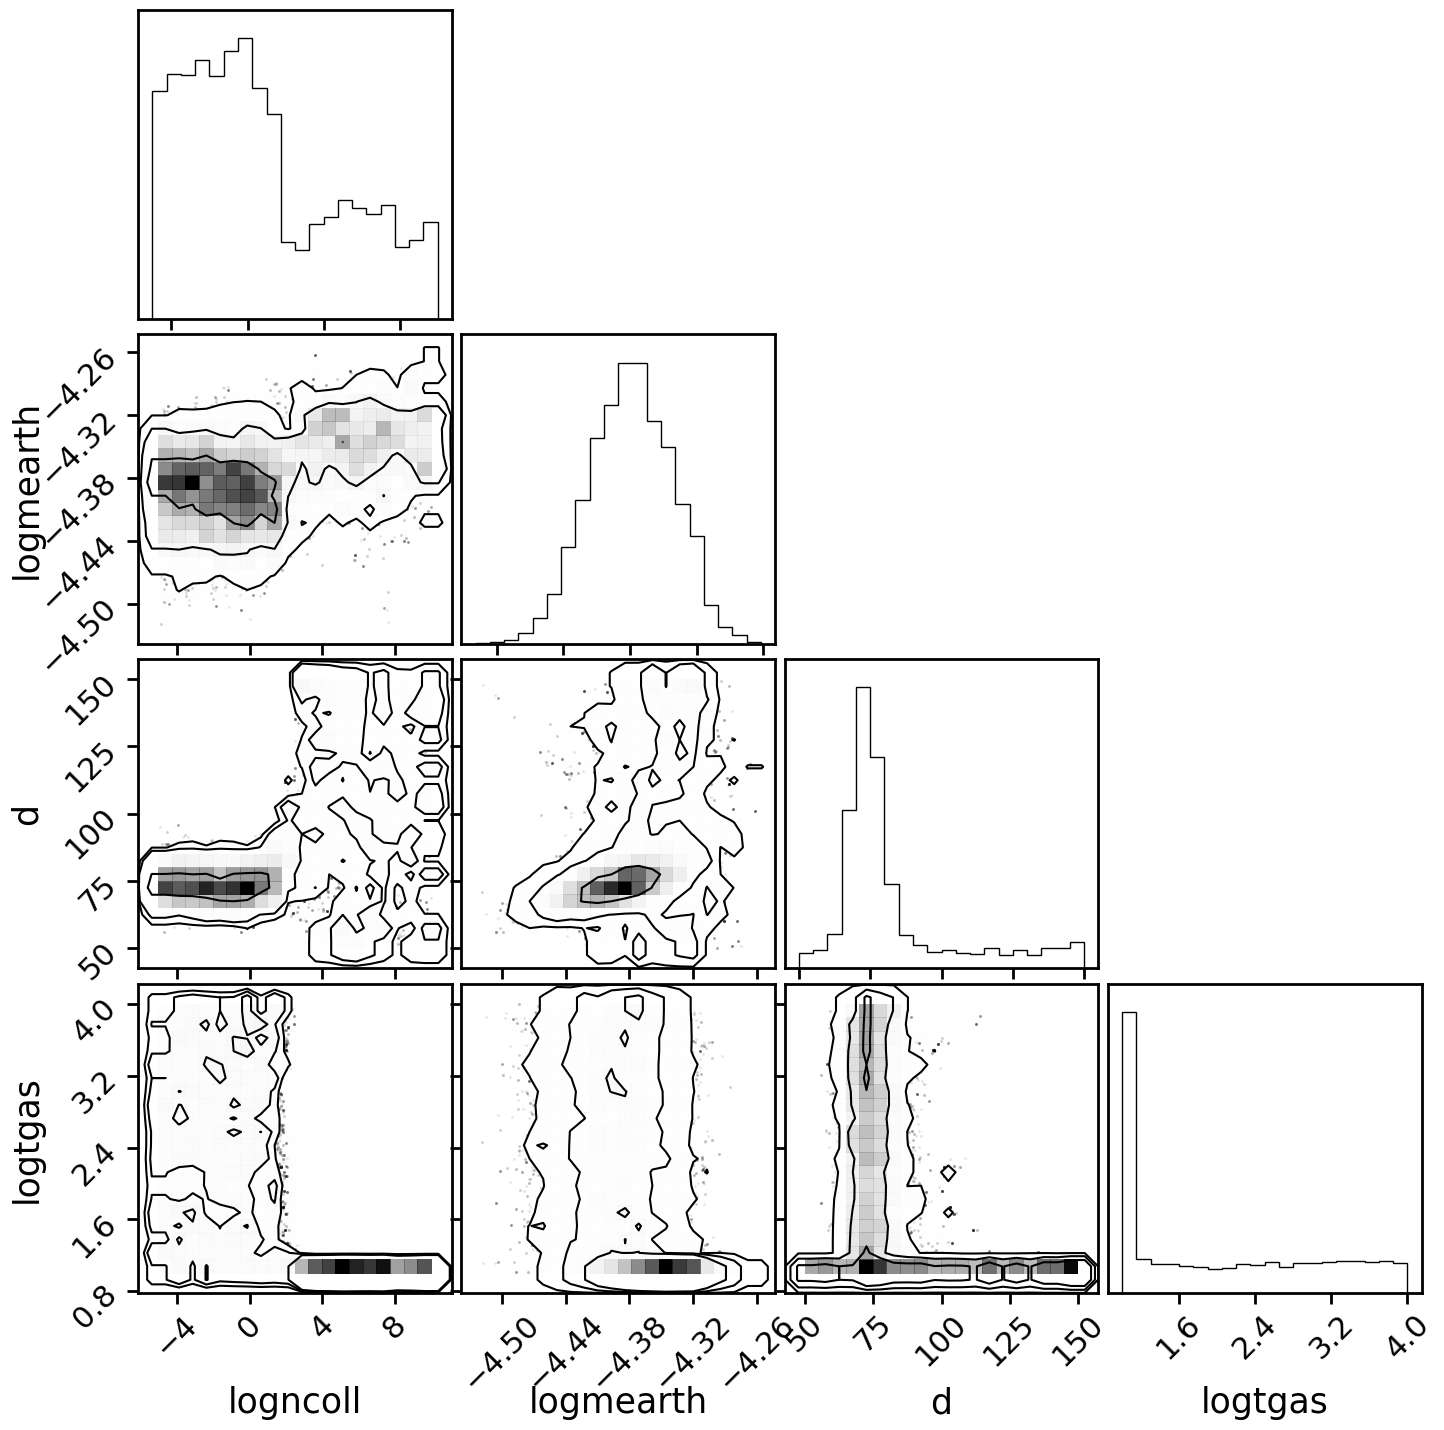

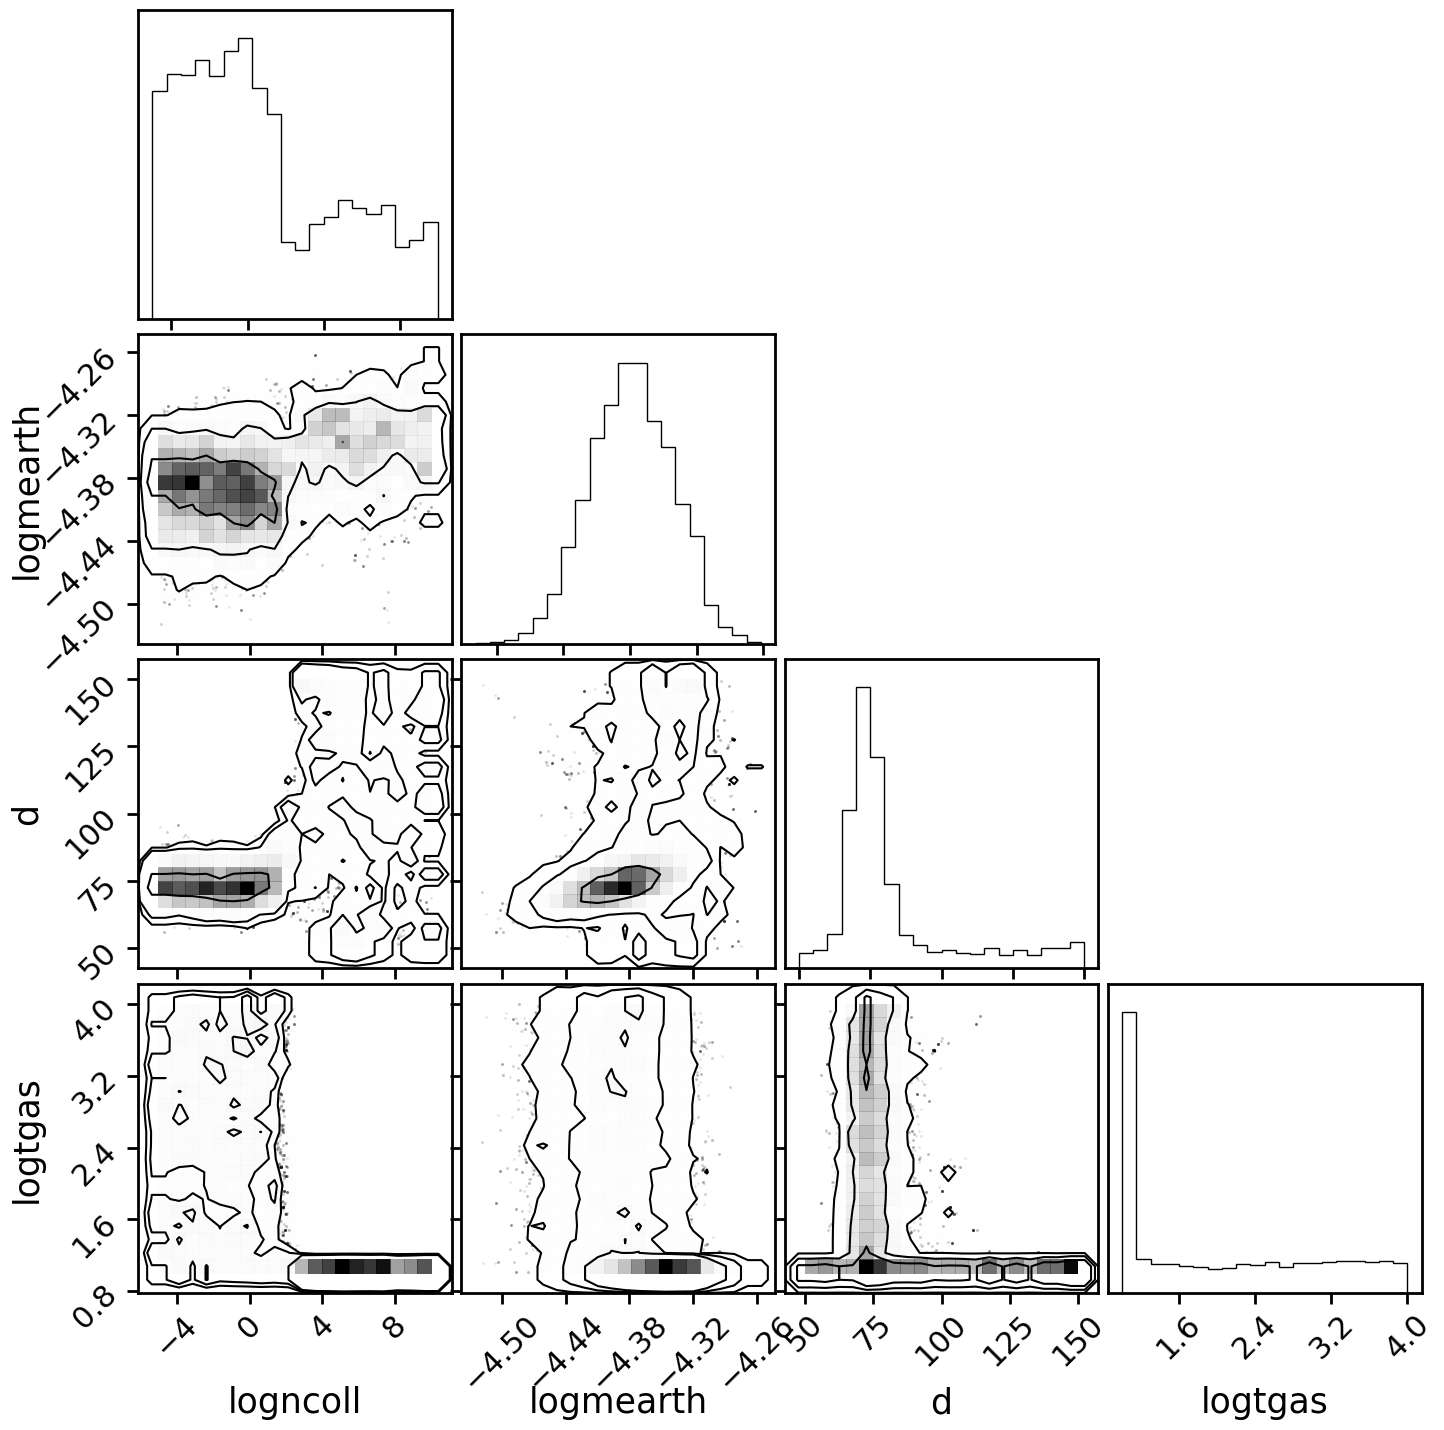

In [23]:
burnin=1000
flat_samples = sampler.get_chain(discard=burnin, flat=True)
import corner
fig, ax=pl.subplots(ndim,ndim,figsize=(15,15), gridspec_kw={'wspace': 0.03})
corner.corner(flat_samples, fig=fig, labels=labels, levels=1.0 - np.exp(-0.5 * (np.arange(3)+1.0) ** 2))

In [24]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
x=2.9979e8*1e6/np.array([115.271,230.538,345.596])/1e9
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    logncoll, logmearth, d, logtgas = sample
    fluxallsi = elrovibpopcalc_CO.elrovibpopcalc_COfunc(tgas=10**logtgas, ncollp=10**logncoll, jnufilestar='./bPic_starfluxJyfromEarth.npy', datafile='./COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat', linewithntrcoll=114067, distpc=distpc, distau=d, levupint='all', si=1, massmearth=10**logmearth)
    model=np.array([fluxallsi[8], fluxallsi[17], fluxallsi[26]])*1e26/np.array([115.271,230.538,345.596])/1e9*2.9979e5
    pl.plot(x, model, "C1", alpha=0.1)
pl.errorbar(x, y*1e26/np.array([115.271,230.538,345.596])/1e9*2.9979e5, yerr=yerr*1e26/np.array([115.271,230.538,345.596])/1e9*2.9979e5, fmt=".k", capsize=0)
#pl.legend(fontsize=14)
#pl.xlim(0, 10)
pl.xlabel("Wavelength ($\mu$m)")
pl.ylabel("Line flux (Jy km/s)")
pl.yscale('log')
pl.xscale('log')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error!
Excitation file was not found!
Traceback (most recent call last):
  File "/home/users/lmatra/nesps/tutorial/../utils/elrovibpopcalc_CO.py", line 58, in elrovibpopcalc_COfunc
    rfile = open(fname, 'r')
FileNotFoundError: [Errno 2] No such file or directory: './COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/users/lmatra/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3283558/3058225292.py", line 6, in <module>
    fluxallsi = elrovibpopcalc_CO.elrovibpopcalc_COfunc(tgas=10**logtgas, ncollp=10**logncoll, jnufilestar='./bPic_starfluxJyfromEarth.npy', datafile='./COvibrot_Lambda_nelec2_nvib9_nrot30.dat_corrected.dat', linewithntrcoll=114067, distpc=distpc, distau=d, levupint='all', si=1, massmearth=10**logmearth)
  File "/home/users/l

TypeError: object of type 'NoneType' has no len()